PIA

Hannia Soto Zurita 1948211

Edilson Alejandro Hernández López 2109291

José Eduardo Salazar Arellano 2109211

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras.models import Sequential
import numpy as np
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

# Preprocesamiento de las imágenes

In [ ]:
#Función para almacenar los datos con su etiqueta, si es normal es de clase 1 y si tiene neumonía es clase 0
labels = ['PNEUMONIA', 'NORMAL']
img_size_a = 128
img_size_b = 128
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size_a, img_size_b)) # Reescalado de imagenes a resolución de 128x128
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return data

In [ ]:
#Uso de la función para los datos de entrenamiento y de prueba
train = get_training_data('/content/gdrive/MyDrive/Data_Set_PIA/datos_neumonia/chest_xray/train')
test = get_training_data('/content/gdrive/MyDrive/Data_Set_PIA/datos_neumonia/chest_xray/test')

In [ ]:
#Normalización de los datos
train_images = []
train_labels = []

test_images = []
test_labels = []

for feature, label in train:
    train_images.append(feature)
    train_labels.append(label)

for feature, label in test:
    test_images.append(feature)
    test_labels.append(label)

In [ ]:
train_images = np.array(train_images) / 255
test_images = np.array(test_images) / 255
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [ ]:
# Cambio del tamaño de los datos
train_images = train_images.reshape(-1, img_size_a, img_size_b, 1)
train_labels = np.array(train_labels)

test_images = test_images.reshape(-1, img_size_a, img_size_b, 1)
test_labels = np.array(test_labels)

In [ ]:
# con técnicas para aumentar los datos reducimos la probabilidad de que el modelo se sobreajuste

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # rotar imágenes
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # mover imágenes horizontalmente
        height_shift_range=0.1,  # mover imágenes verticalmente
        horizontal_flip = True,  # voltear imágenes horizontalmente
        vertical_flip=False)  # randomly flip images


datagen.fit(train_images)

# Diseño y entenamiento de la CNN

In [ ]:
# Parte convolusional de la RNAC

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128,1)))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

In [ ]:
# Parte de clasificación
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))#1 neurona de salida ya que solo contamos con 2 valores, falso o verdadero.

In [ ]:
# Compliación del modelo: características
model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 61, 61, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

In [ ]:
#Reajuste de la tasa de aprendizaje del modelo
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(train_images, train_labels, batch_size=32, epochs=10,
                    validation_data=(test_images, test_labels),
                    callbacks=[learning_rate_reduction])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


163/163 [==============================] - 217s 1s/step - loss: 0.2591 - accuracy: 0.9225 - val_loss: 8.8490 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 212s 1s/step - loss: 0.1203 - accuracy: 0.9551 - val_loss: 12.1285 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.0813 - accuracy: 0.9716
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 216s 1s/step - loss: 0.0813 - accuracy: 0.9716 - val_loss: 9.3287 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 216s 1s/step - loss: 0.0345 - accuracy: 0.9864 - val_loss: 1.8397 - val_accuracy: 0.7115 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - 216s 1s/step - loss: 0.0274 - accuracy: 0.9898 - val_loss: 1.8017 - val_accuracy: 0.6939 - lr: 3.0000e-04
Epoch 6/10
163/163 [==============================] - ETA: 0s

# Evaluación del modelo

20/20 - 5s - loss: 1.0781 - accuracy: 0.8253 - 5s/epoch - 259ms/step


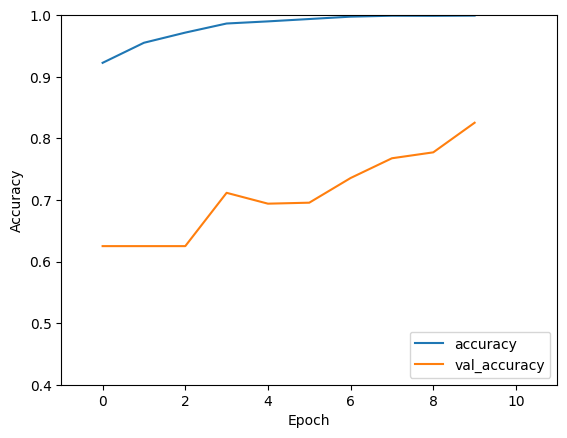

In [ ]:
#Gráfica con la diferencia de valores de exactitud del entrenamiento y la validación.

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1])
plt.xlim([-1, 11])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

**Sobreajuste en el modelo entrenado**

En la gráfica anterior se puede apreciar una clara diferencia entre la exactitud del entrenamiento y de la prueba, esto se debe a un claro sobreajuste en el modelo entrenado, que aprendió características muy específicas del conjunto de datos de entrenamiento por lo que al momento de encontrarse con un conjunto de datos nuevo se basa mucho en los datos de entrenamiento y no cuenta con una capacidad de generalizar para obtener predicciones correctas.

In [ ]:
#obtención de predicciones y cambio a predicciones binarias
predictions = model.predict(test_images)
binary_predictions = (predictions >= 0.5).astype(int)
binary_predictions= binary_predictions.reshape(1,-1)[0]
binary_predictions

20/20 [==============================] - 6s 265ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
#Predicción 1
x = binary_predictions[1]
y = test_labels[1]
print(f"La red dice que la imagen es clase {x} y la clase verdadera es: {y}")

La red dice que la imagen es clase 0 y la clase verdadera es: 0


In [ ]:
#Predicción 2
x = binary_predictions[-1]
y = test_labels[-1]
print(f"La red dice que la imagen es clase {x} y la clase verdadera es: {y}")

La red dice que la imagen es clase 1 y la clase verdadera es: 1


In [ ]:
#Predicción 3
x = binary_predictions[50]
y = test_labels[50]
print(f"La red dice que la imagen es clase {x} y la clase verdadera es: {y}")

La red dice que la imagen es clase 0 y la clase verdadera es: 0


In [ ]:
#Predicción 4
x = binary_predictions[100]
y = test_labels[100]
print(f"La red dice que la imagen es clase {x} y la clase verdadera es: {y}")

La red dice que la imagen es clase 0 y la clase verdadera es: 0


In [ ]:
#Predicción 5
x = binary_predictions[500]
y = test_labels[500]
print(f"La red dice que la imagen es clase {x} y la clase verdadera es: {y}")

La red dice que la imagen es clase 1 y la clase verdadera es: 1


In [ ]:
correct = np.nonzero(binary_predictions == test_labels)[0]
incorrect = np.nonzero(binary_predictions != test_labels)[0]

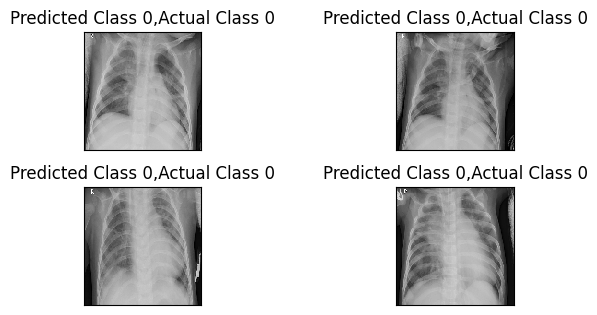

In [ ]:
#Algunas predicciones correctas
i = 0
for c in correct[:4]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_images[c].reshape(128,128), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(binary_predictions[c], test_labels[c]))
    plt.tight_layout()
    i += 1

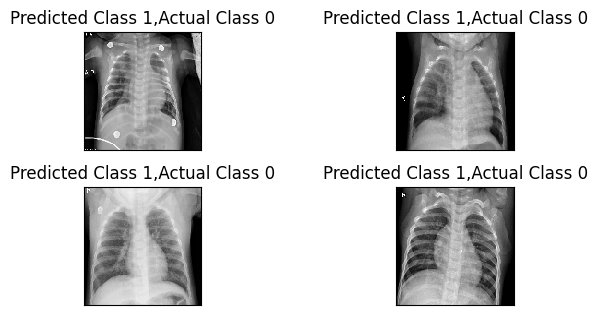

In [ ]:
#Algunas predicciones incorrectas
i = 0
for c in incorrect[:4]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_images[c].reshape(128,128), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(binary_predictions[c], test_labels[c]))
    plt.tight_layout()
    i += 1